[34 多GPU训练实现](https://www.bilibili.com/video/BV1MQ4y1R7Qg/?spm_id_from=333.788.recommend_more_video.0)

In [1]:
# 只能薅公司羊毛了
!nvidia-smi

Mon May 23 01:07:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:02:00.0 Off |                  N/A |
| 22%   32C    P8     9W / 250W |      1MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:03:00.0 Off |                  N/A |
| 22%   

In [2]:
import torch
from torch import nn
from torch.functional import F
from d2l import torch as d2l

In [3]:
# 初始化模型参数
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]

# 定义模型
def lenet(X, params):
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat

# 交叉熵损失函数
loss = nn.CrossEntropyLoss(reduction='none')

- 对于高效的多GPU训练，我们需要两个基本操作。 首先，我们需要向多个设备分发参数并附加梯度（get_params）。 如果没有参数，就不可能在GPU上评估网络。 第二，需要跨多个设备对参数求和，也就是说，需要一个allreduce函数。
- 该函数用于分发参数，位于cpu中

In [4]:
def get_params(params, device):
#     clone是出于保险起见
    new_params = [p.to(device) for p in params]
    for p in new_params:
#         这些参数都是需要梯度的
        p.requires_grad_()
    return new_params

In [5]:
# 通过将模型参数复制到一个GPU。
new_params = get_params(params, d2l.try_gpu(0))
print('b1 权重:', new_params[1])
print('b1 梯度:', new_params[1].grad)

b1 权重: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1 梯度: None


- 由于还没有进行任何计算，因此权重参数的梯度仍然为零。 
- 假设现在有一个向量分布在多个GPU上，下面的allreduce函数将所有向量相加，并将结果广播给所有GPU。 

In [6]:
# allreduce函数将所有向量相加，并将结果广播给所有GPU
def allreduce(data):
    for i in range(1, len(data)):
#         data[0][:]可以使得数据在原空间上修改，没有[:]会重新分配地址
        data[0][:] += data[i].to(data[0].device)
    for i in range(1, len(data)):
        data[i][:] = data[0].to(data[i].device)

In [7]:
data = [torch.ones((1, 2), device=d2l.try_gpu(i)) * (i + 1) for i in range(2)]
print('allreduce之前：\n', data[0], '\n', data[1])
allreduce(data)
print('allreduce之后：\n', data[0], '\n', data[1])

allreduce之前：
 tensor([[1., 1.]], device='cuda:0') 
 tensor([[2., 2.]], device='cuda:1')
allreduce之后：
 tensor([[3., 3.]], device='cuda:0') 
 tensor([[3., 3.]], device='cuda:1')


我们需要一个简单的工具函数，将一个小批量数据均匀地分布在多个GPU上。 例如，有两个GPU时，我们希望每个GPU可以复制一半的数据。 因为深度学习框架的内置函数编写代码更方便、更简洁，所以在$(4 \times 5)$矩阵上使用它进行尝试。

In [8]:
# 数据均匀的分配到每个GPU上
data = torch.arange(20).reshape(4, 5)
devices = [torch.device('cuda:0'), torch.device('cuda:1')]
# 这里是利用torch进行分发
split = nn.parallel.scatter(data, devices)
print('input :', data)
print('load into', devices)
print('output:', split)

input : tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
load into [device(type='cuda', index=0), device(type='cuda', index=1)]
output: (tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]], device='cuda:0'), tensor([[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]], device='cuda:1'))


In [9]:
# 可以利用pytorch创建一个分发函数
def split_batch(X,y,device):
    assert X.shape[0] == y.shape[0]
    return (nn.parallel.scatter(X, devices),
            nn.parallel.scatter(y, devices))

In [10]:
# 如何在一个小批量上实现多GPU训练
def train_batch(X, y, device_params, devices, lr):
    X_shards, y_shards = split_batch(X, y, devices)
    # 在每个GPU上分别计算损失
    ls = [loss(lenet(X_shard, device_W), y_shard).sum()
          for X_shard, y_shard, device_W in zip(
              X_shards, y_shards, device_params)]
    for l in ls:  # 反向传播在每个GPU上分别执行
# 需要指出的是这里可能存在一个问题，因为光从代码本身而言，
# 这里像是串行操作，就是每个GPU依次进行训练，能不能实现并行操作，得依赖于框架本身是否能做到
        l.backward()
    # 将每个GPU的所有梯度相加，并将其广播到所有GPU
    with torch.no_grad():
        for i in range(len(device_params[0])):
            allreduce(
                [device_params[c][i].grad for c in range(len(devices))])
    # 在每个GPU上分别更新模型参数
    for param in device_params:
        d2l.sgd(param, lr, X.shape[0]) # 在这里，我们使用全尺寸的小批量

In [11]:
# 完整训练写法
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    # 在开始训练之前，就要将模型参数复制到num_gpus个GPU
    device_params = [get_params(params, d) for d in devices]
    num_epochs = 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            # 为单个小批量执行多GPU训练
            train_batch(X, y, device_params, devices, lr)
#           此函数目的是为了确认每个GPU都训练完毕  
            torch.cuda.synchronize()
        timer.stop()
        # 在GPU0上评估模型
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(
            lambda x: lenet(x, device_params[0]), test_iter, devices[0]),))
    print(f'测试精度：{animator.Y[0][-1]:.2f}，{timer.avg():.1f}秒/轮，'
          f'在{str(devices)}')

测试精度：0.78，2.6秒/轮，在[device(type='cuda', index=0)]


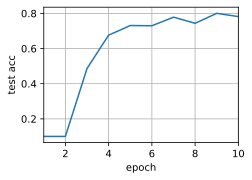

In [12]:
train(num_gpus=1, batch_size=256, lr=0.2)

测试精度：0.79，2.8秒/轮，在[device(type='cuda', index=0), device(type='cuda', index=1)]


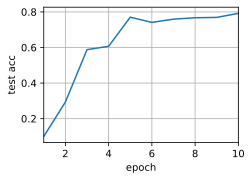

In [18]:
# 多GPU训练的时候，可以考虑更大的batch和lr
# 此外这种写法对于torch不是特别时候并行
train(num_gpus=2, batch_size=256*2, lr=0.2*1.5)